In [ ]:
import requests
from bs4 import BeautifulSoup
import threading
import json
from data.crawler.data_objects import Api, ApiVersion, Changelog, DeadPoolApi

# Sep.16, 2020
max_page = 948

In [ ]:
# Assist function. Split a list
def list_split(list_info, per_list_len):
    """
    :param list_info:   列表
    :param per_list_len:  每个小列表的长度
    :return:
    """
    list_of_group = zip(*(iter(list_info),) * per_list_len)
    end_list = [list(i) for i in list_of_group]  # i is a tuple
    count = len(list_info) % per_list_len
    end_list.append(list_info[-count:]) if count != 0 else end_list
    return end_list

In [ ]:
pages = [i for i in range(max_page)]
pages_split = list_split(pages, 8)    # Split the pages for multi-threads work
pages_split     # preview

In [ ]:
# Save the URLs for future works.
base = 'https://www.programmableweb.com/category/all/apis?deadpool=1&page='
api_links = {}
failed_page_idx = []    # save the page number when no table is found


def get_list(thread_count, pages):
    """
    The work for a single thread.
    # todo
    """
    thread_count[0] += 1
    for page in pages:
        url = base + str(page)
        req = requests.get(url)
        bs = BeautifulSoup(req.text, features='html.parser')
        tds = bs.find_all('td', class_='views-field-pw-version-title')
        if tds is None:
            failed_page_idx.append(page)
        for td in tds:
            a = td.find('a')
            href = a.get('href')
            title = a.text.strip()
            api_links[href] = title
    
    thread_count[0] -= 1

In [ ]:
max_thread = 40
thread_count = [0]

# page = 0
# A simple but unsafe way to use multi-threads
i = 0
length = len(pages_split)
while True:
    if i >= length:
        break
    if thread_count[0] < max_thread:
        # For each thread, get all API detail links in a page.
        t = threading.Thread(target=get_list, args=(thread_count, pages_split[i]))
        t.start()
        print('Created a new thread. Processing the ', (i + 1), 'th sublist. There are ', length, 'sublists in all.')
        i += 1

In [ ]:
len(api_links)  # preview

23676

In [ ]:
# Save the links to a text file
with open('api_links0909-1.txt', 'w', encoding='utf-8') as file:
    for link in api_links:
        file.write(link + '\n')


In [ ]:
# Get the detail information of an API
def get_api(url, is_dead_api=False):
    req_api = requests.get('https://www.programmableweb.com' + url)
    bs_api = BeautifulSoup(req_api.text, features='html.parser')
    # 找node-header，锁定标题
    node_header = bs_api.find('div', class_='node-header')
    if node_header is None:
        # 失败
        failed_api_hrefs.append(url)
        print('failed')
        return None
    title = node_header.find('h1').text.strip()     # title

    tags = []   #tags
    div_tags = bs_api.find('div', class_='tags')
    tags_a = div_tags.find_all('a')
    for a in tags_a:
        tags.append(a.text.strip())

    intro = bs_api.find('div', class_='intro')
    description = ''
    if intro is None:
        # 失败
        failed_api_hrefs.append(url)
        print('not found intro')
    else:
        description_div = intro.find('div', class_='api_description')
        if description_div is None:
            # failed_api_hrefs.append(url)
            print('not found description_div')
        else:
            description = description_div.text.strip()  #description

    # 定位版本versions
    versions = []
    version_field = bs_api.find('div', id='version-details-field')
    version_results = version_field.find_all('div', class_='version-result-set')
    
    # 开始获取版本
    for result in version_results:
        divs = result.find_all('div')
        version_title = ''
        version_style = ''
        version_status = ''
        version_version = ''
        version_submit_date = ''
        version_link = ''
        for div in divs:
            # 直接找所有div，根据label去匹配
            label = div.find('label')
            if label is None:
                # 不是我要的div
                continue
            else:
                lt = label.text.strip()
                version_info = div.text.strip()
                if lt == 'Title:':
                    version_title = version_info.split(':')[1]
                    # 寻找a标签
                    version_a = div.find('a')
                    if version_a is None:
                        print('not found a tag of this version')
                        version_link = 'not found'
                    else:
                        version_link = version_a.get('href')
                elif lt == 'Style:':
                    version_style = version_info.split(':')[1]
                elif lt == 'Version:':
                    version_version = version_info.split(':')[1]
                elif lt == 'Status:':
                    # 这个没发现什么好的办法，直接取得所有span
                    spans = div.find_all('span')
                    # 因为0是那个mobile，我不需要，只需要1
                    span = spans[1]
                    version_status = span.text.strip()
                elif lt == 'Submitted:':
                    version_submit_date = version_info.split(':')[1]
        version = ApiVersion(version_title, version_style, version_status, version_version, version_submit_date, version_link)
        versions.append(version)

    # 创建API对象
    if is_dead_api:
        # 是已经dead的API，获得他的changelog，以推算API的死亡日期
        # 获得changelogs
        changelogs = get_changelogs(url)
        deprecated_date = 'Not sure'
        if len(changelogs) == 1:
            deprecated_date = changelogs[0].split('|')[0]
        api = DeadPoolApi(title, tags, description, url, versions, changelogs, deprecated_date)
    else:
        api = Api(title, tags, description, url, versions)
    # apis[url] = api
    # print(api.title)
    return api

def threads_get_api(thread_count, api_list):
    thread_count[0] += 1
    for url in api_list:
        api = get_api(url)
        apis.append(api)
    thread_count[0] -= 1

def threads_get_dead_api(thread_count, api_list):
    thread_count[0] += 1
    for url in api_list:
        api = get_api(url, is_dead_api=True)
        apis.append(api)
    thread_count[0] -= 1

In [ ]:
# 9.9 爬取deadpool的补充，因为需要爬changelog才有可能确定
# 现在做两件事：
# 1. 爬取API的changelog，有可能会写出"deadpool"，然后获取这个log的日期
# 2. 爬取API的各个已经不活跃的version的changelog，有可能出现"deactiveted"
# changelog_map = {}
def get_changelogs(url):
    changelogs = []
    change_req = requests.get('https://www.programmableweb.com' + url + '/changelog')
    cbs = BeautifulSoup(change_req.text, features='html.parser')    # changelog beautiful soup
    changelog_divs = cbs.find_all('p', class_='changelog_divider')
    for changelog_div in changelog_divs:
        changelog_text = changelog_div.get_text("|", strip=True)
        if 'deadpool' in changelog_text.lower():
            print(True)
            # 有用的changelog
            changelogs.append(changelog_text)
    return changelogs


In [ ]:
api_list = list(api_links.keys())

api_list1 = api_list[:5000]
api_list2 = api_list[5000:10000]
api_list3 = api_list[10000:15000]
api_list4 = api_list[15000:20000]
api_list5 = api_list[20000:]

NameError: ignored

In [ ]:
# 写文件
with open('file5.txt', 'w', encoding='utf-8') as file2:
    for aaa in api_list5:
        file2.write(aaa + '\n')

In [ ]:
# 读文件
api_list3 = []
with open('file3.txt', 'r', encoding='utf-8') as file:
    for line in file:
        api_list3.append(line)

In [ ]:
# api_lists = [api_list1, api_list2, api_list3, api_list4, api_list5]

In [ ]:
# load the five files
api_lists = []
i = 0
for i in range(1, 6):
    temp_list = []
    with open('file' + str(i) + '.txt', 'r', encoding='utf-8') as file:
        for line in file:
            temp_list.append(line)
    api_lists.append(temp_list)

In [ ]:
splits = []
for al in api_lists:
    splits.append(list_split(al, 12))
len(splits)

5

In [ ]:
max_thread = 80
thread_count = [0]

apis = []   
failed_api_hrefs = []   # empty the failed links
threads = []

for idx in range(len(splits)):  # idx file index. 0~4(5 files in all)
    # better to run the code below manually for 5 times.
    now_list = splits[idx]
    i = 0
    length = len(now_list)
    thread_count[0] = 0
    while True:
        if i >= length:
            break
        if thread_count[0] <= max_thread:
            t = threading.Thread(target=threads_get_api, args=(thread_count, now_list[i]))
            threads.append(t)
            t.start()
            print('Created a new thread. Processing the ', (i + 1), 'th sublist. There are', length, 'sublists in all')
            i += 1

In [ ]:
# preview
print(json.dumps(obj=apis[:2], default=lambda x : x.__dict__, sort_keys=False, indent=2))

[
  {
    "title": "Dextro Image Recognition API MASTER RECORD",
    "tags": [
      "Photos",
      "Recognition"
    ],
    "description": "Dextro Image Recognition is a service that allows for object recognition in images. Dextro's functionality recognizes objects and the location of objects in images.\nThe Dextro Image Recognition API allows developers to access and integrate the functionality of Dextro with other applications. Public documentation is not available; interested developers should sign up here for API access: https://www.dextrorobotics.com/signup.",
    "url": "/api/dextro-image-recognition\n",
    "versions": [
      {
        "version_title": "Dextro Image Recognition REST API",
        "style": "REST",
        "version": "Recommended (active, supported)",
        "status": "N/A",
        "submit_date": "01.15.2013",
        "version_link": "/api/dextro-image-recognition-rest-api"
      }
    ]
  },
  {
    "title": "BriteVerify API MASTER RECORD",
    "tags": [
   

In [ ]:
# 成功的列表写入文件
with open('apilist5-0915-1.txt', 'w', encoding='utf-8') as file1:
    file1.write(json.dumps(obj=apis, default=lambda x : x.__dict__, sort_keys=False, indent=2))   

In [ ]:
# 失败的列表（全是链接）写入文件
with open('failedapilist5-0915-1.txt', 'w', encoding='utf-8') as file1:
    for href in failed_api_hrefs:
        file1.write(href)   

In [ ]:
# 最后爬一下失败的链接
failed_hrefs = []
with open('failedapilist1-5.txt', 'r', encoding='utf-8') as failed:
    for line in failed:
        failed_hrefs.append(line)

# preview
print(len(failed_hrefs))    # need to be re-crawled
print(failed_hrefs[:10])

105
['/api/google-url-shortener\n', '/api/aonaware-dictionary\n', '/api/salesforce\n', '/api/change-healthcare\n', '/api/joinesty\n', '/api/musicmobs\n', '/api/strain\n', '/api/us-yellow-pages\n', '/api/winecom\n', '/api/windows-live-gadgets\n']


# New requirements - Accessibility

- Acccess to the Endpoint Address to recognize whether the API is still accessible
- Save the status code/accessibility
- The Endpoint Address appears in each version's link, so I have to access to every version's URL
- Test the versions marked as Active. For those versions which are alreay deactivated will not be tested. 

## How to decide an API's accessibility
- By its versions data
    1. For all versions in one API, and look up the status provided by ProgrammableWeb.
    2. If all versions are marked as deactivated, this API is a dead API. If not(at least one version is active), it will be marked as active, and further tests will be done.
- Further tests: access to its website
    1. For all active APIs's versions, access to their Endpoing Address.
    2. If none of the websites is accessible, the API will be marked as deactivated, else active.

------

Note: NOT deactived. IT'S deactivated

In [ ]:
# Load the API dataset.
with open('apis0915.txt', 'r', encoding='utf-8') as file:
    apis_list = json.loads(text)
    apis_list = [at for at in apis_list if at is not None]

apis_list[:5]   # preview

In [ ]:
# Note: This cell is used to filter the APIs which are marked as active in ProgrammableWeb
# These active APIs need to be tested more in the below cells.

apis = []
all_versions = []   # 存储不管是什么API的version，最后用到它的长度
active_apis = []    # 标记为活跃的API
deactive_apis = []      # 标记为不活跃的API （所有version都是deactivate）
for api in apis_list:
    versions = []
    is_active_api = False   # 后面遍历所有version，如果全部都是deactivate的，那么这个标记就是False
    for version in api['versions']:
        api_version = ApiVersion('', '', '', '', '', '')
        api_version.__dict__ = version
        versions.append(api_version)
        all_versions.append(api_version)
        if api_version.version is not 'Deactivated':
            is_active_api = True

    aaa = Api(api['title'], api['tags'], api['description'], api['url'], versions)
    apis.append(aaa)
    if is_active_api:
        active_apis.append(aaa)
    else:
        deactive_apis.append(aaa)

In [ ]:
# 看看数量
print('All apis:', len(apis))
print('All versions:', len(all_versions))
print('Active apis:', len(active_apis))
print('Deactive apis:', len(deactive_apis))

All apis: 21569
All versions: 22207
Active apis: 21566
Deactive apis: 3


In [ ]:
print(apis[0].json())

In [ ]:
actived_versions = {}
a_apis = []
# version_title->Api
i = 0
for api_dict in apis:
    # 选出非deactived的api和他的version
    a_apis.append(api_dict)
    versions = api_dict['versions']
    for version in versions:
        if version['version'] is not 'Deactivated':
            actived_versions[version['version_title']] = api_dict
    i += 1    


In [ ]:
keys = list(actived_versions.keys())    # keys 就是title列表
keys[0].json()

'{\n  "version_title": "Envato REST API",\n  "style": "REST",\n  "version": "Recommended (active, supported)",\n  "status": "N/A",\n  "submit_date": "03.02.2011",\n  "version_link": "/api/envato-rest-api"\n}'

In [ ]:
from data.crawler.data_objects import SimplifiedApi, VersionVisit, VisitStatus

In [ ]:
# 定义多线程爬取versions的方法
# 部分API可以按照把版本的名字中的空格修改为短横线作为URL
base_url = 'https://www.programmableweb.com'
def get_version(version):
    # 制作URL
    url = base_url + version.version_link
    req = requests.get(url)

    version_title = version.version_title
    version_url = url
    visit_status = []
    is_accessible = False

    from_api_dict = actived_versions[version]
    api_title = from_api_dict.title
    api_url = from_api_dict.url
    from_api = SimplifiedApi(api_title, api_url)
    is_endpoint_accessbile = 'Undefined'
    is_homepage_accessible = 'Undefined'

    if req.status_code == requests.codes.ok:
        # 成功的
        # 爬取里面的各种a标签
        bs = BeautifulSoup(req.text, features='html.parser')
        specs = bs.find('div', class_='section specs')
        if specs is None:
            cannot_find_html_element.append(url)
        else:
            # 找到了spec的列表
            # 获取所有a标签
            a_tags = specs.find_all('a')
            for a_tag in a_tags:
                # 遍历所有a标签，然后找他们的父节点，找到label
                # 然后访问这个a标签，记录下访问状态
                label = a_tag.parent.parent.find('label')
                if label is None:
                    print('not found label. URL:', url)
                    label_text = 'Undefined'
                else:
                    label_text = label.text.strip()
                a_href = a_tag.get('href')
                if 'http' not in a_href:
                    # 这个href就不访问了，因为是站内的
                    continue

                visit_url = a_href
                visit_label = label_text
                status_code = 0

                # 访问a标签
                try:
                    a_req = requests.get(a_href)
                    status_code = a_req.status_code
                except:
                    status_code = -1

                # 这里仅利用 end point 去判断 is accessible or not
                if label_text == 'API Endpoint':
                    if status_code == 200 or status_code == 429:
                        # 只有200才标记为True，否则都是False
                        is_accessible = True    # tag it as accessible
                        is_endpoint_accessbile = True
                    else:
                        is_endpoint_accessbile = False
                elif 'Portal' in label_text:
                    if status_code == 200 or status_code == 429:
                        # 只有200才标记为True，否则都是False
                        is_homepage_accessible = True
                    else:
                        is_homepage_accessible = False

                
                status = VisitStatus(visit_url, visit_label, status_code)
                visit_status.append(status)
        a_visit = VersionVisit(version_title, version_url, from_api, visit_status, is_accessible, is_endpoint_accessbile, is_homepage_accessible)
        # version_visits.append(a_visit)
        visited_url.append(version_url)
        return a_visit
    else:
        # 不知道是什么原因失败了，但是很可能是404
        failed_version_url.append(url)
        print('failed', url)


# The work for each thread
def threads_get_version_visit(thread_count, version_list):
    thread_count[0] += 1
    for version in version_list:
        a_visit = get_version(version)    # 获取一次访问结果
        # 判断是否为None
        if a_visit is not None:
            version_visits.append(a_visit)
    thread_count[0] -= 1

In [ ]:
# len(keys)   # 22239
# 分割列表
splits_temp = list_split(keys, 5000)
splits = []
for list_ in splits_temp:
    splits.append(list_split(list_, 8))
print(len(splits[0]))

625


In [ ]:
# Similar to crawling the API details
failed_version_url = []
cannot_find_html_element = []
version_visits = []
available_status = [200, 429]
visited_url = []
# 多线程爬取
max_thread = 60
thread_count = [0]

# Change this idx number to access to different sublist at different time to prevent ip being banned
# When finished one sublist, save as a text file
idx = 4
now_list = splits[idx]
i = 0
length = len(now_list)
while True:
    if i >= length:
        break
    if thread_count[0] <= max_thread:
        t = threading.Thread(target=threads_get_version_visit, args=(thread_count, now_list[i]))
        t.start()
        print('Created a new thread. Processing the ', (i + 1), 'th sublist. There are', length, 'sublists in all')
        i += 1

# ensure the list of failed links is empty
# ensure the list of failed links is empty
# ensure the list of failed links is empty

# preivew
print(json.dumps(obj=version_visits[:10], default=lambda x : x.__dict__, sort_keys=False, indent=2))

# save to file
with open('version_status0915-5.txt', 'w', encoding='utf-8') as file:
    # json.dump is better
    file.write(json.dumps(obj=version_visits, default=lambda x : x.__dict__, sort_keys=False, indent=2))


In [ ]:
# accessible versions ratio
accessible = 0
for vis in version_visits:
    for status in vis.visit_status:
        if status.visit_label == 'API Portal / Home Page':
            if status.status_code == 200 or status.status_code == 429:
                accessible += 1
            break
print(float(accessible) / len(version_visits))

0.536330608537693


# Trying visualization

分成多个图
- 按照version绘图，表示出标记正确的version和标记错误的version以及占比
- 按照API绘图，以API的链接作为区分，表示出正确和错误的占比
- 分别以可否访问endpoint 和 portal/homepage 作为API是否存活的依据，绘制上面两个图

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# 读取version_status 文件
version_visits = []
for i in range(1, 6):
    text = ''
    with open('version_status0915-' + str(i) + '.txt', 'r', encoding='utf-8') as file:
        text = file.read()
    # json 解析
    version_visits_dicts = json.loads(text)

    for visit_dict in version_visits_dicts:
        from_api_dict = visit_dict['from_api']
        from_api = SimplifiedApi(from_api_dict['api_title'], from_api_dict['url'])
        visit_status_list = []
        for status in visit_dict['visit_status']:
            visit_status_list.append(VisitStatus(status['visit_url'], status['visit_label'], status['status_code']))
        version_visits.append(VersionVisit(visit_dict['version_title'], visit_dict['version_url'], from_api, visit_status_list, visit_dict['is_accessible'], visit_dict['is_endpoint_accessbile'], visit_dict['is_homepage_accessible']))

6175036
5673184
5142386
4539876
1916781


In [ ]:
len(version_visits)

22055

In [ ]:
def is_active_api(api_link):
    for api in active_apis:
        if api.url == api_link:
            return True
    return False

In [ ]:
def show_pie(version_visits):
    # 分成四个图
    # 先统计
    # 1. 按照 endpoint 统计
    # 2. 按照 portal 统计
    apis = set()
    endpoint_accessible_versions = []
    endpoint_accessible_apis = set()
    homepage_accessible_versions = []
    homepage_accessible_apis = set()
    for visit in version_visits:
        # 如果是对象
        from_api_url = visit.from_api.url.strip()
        apis.add(from_api_url)

        for status in visit.visit_status:
            if status.visit_label == 'API Endpoint':
                if status.status_code == 200 or status.status_code == 429:
                    endpoint_accessible_versions.append(visit)
                    endpoint_accessible_apis.add(from_api_url)      # 这就保证了只要有一个version是可访问的，这个API就作为可访问的
            elif status.visit_label == 'API Portal / Home Page':
                if status.status_code == 200 or status.status_code == 429:
                    homepage_accessible_versions.append(visit)
                    homepage_accessible_apis.add(from_api_url)

    # 统计完了

    # 绘图
    version_length = len(version_visits)
    api_length = len(apis) + 1951

    plt.suptitle("Active versions' accessibility")
    p1 = plt.subplot(1, 2, 1)
    plt.title('API Endpoint')
    endpoint_length = len(endpoint_accessible_versions)
    plt.pie(x=[endpoint_length, version_length - endpoint_length], labels=['Accessible', 'Inaccessible'], autopct='%.2f%%')

    p2 = plt.subplot(1, 2, 2)
    plt.title('API Portal / Home Page')
    homepage_length = len(homepage_accessible_versions)
    plt.pie(x=[homepage_length, version_length - homepage_length], labels=['Accessible', 'Inaccessible'], autopct='%.2f%%')
    plt.show()

    plt.suptitle("Active APIs' accessibility")
    p3 = plt.subplot(1, 2, 1)
    plt.title('API Endpoint')
    endpoint_api_length = len(endpoint_accessible_apis)
    plt.pie(x=[endpoint_api_length, api_length - endpoint_api_length], labels=['Accessible', 'Inaccessible'], autopct='%.2f%%')

    p4 = plt.subplot(1, 2, 2)
    plt.title('API Portal / Home Page')
    homepage_api_length = len(homepage_accessible_apis)
    plt.pie(x=[homepage_api_length, api_length - homepage_api_length], labels=['Accessible', 'Inaccessible'], autopct='%.2f%%')
    plt.show()

    print('Judged by API Endpoint, ' + str(endpoint_api_length) + ' of ' + str(api_length) + ' in all are active')
    print('Judged by API Homepage, ' + str(homepage_api_length) + ' of ' + str(api_length) + ' in all are active')


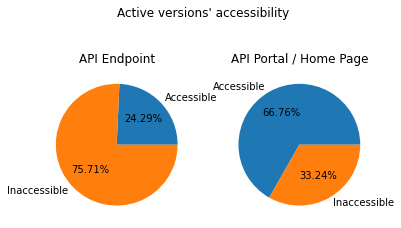

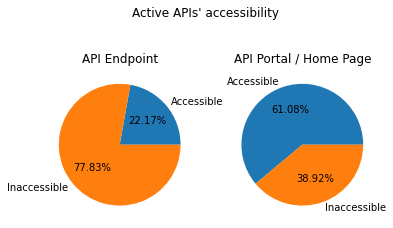

Judged by API Endpoint, 5185 of 23385 in all are active
Judged by API Homepage, 14283 of 23385 in all are active


In [ ]:
show_pie(version_visits)